**Шаг 2: Анализ и обработка дата-сета**


In [24]:
import pandas as pd

# Загрузка данных
file_path = '/content/champions.csv'
data = pd.read_csv(file_path)

# Просмотр первых строк датасета
print(data.head())

# Общая информация о датасете
print(data.info())

# Описание числовых признаков
print(data.describe())


  Champion Name     Role  Base Health  Base Mana  Base Armor  \
0        Aatrox      Top          580          0          38   
1          Ahri      Mid          526        418          21   
2         Akali      Mid          575        200          23   
3       Alistar  Support          600        350          44   
4         Amumu   Jungle          615        285          33   

   Base Attack Damage  Gold Efficiency  
0                  60             1.05  
1                  53             1.02  
2                  62             1.03  
3                  62             1.08  
4                  53             1.06  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Champion Name       149 non-null    object 
 1   Role                149 non-null    object 
 2   Base Health         149 non-null    int64  
 3   Base Mana      

In [26]:
# Проверка на пропущенные значения
print(data.isnull().sum())

# Замена пропущенных значений для числовых данных
numerical_columns = data.select_dtypes(include=['number']).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

# Замена пропущенных значений для строковых данных
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])


Champion Name         0
Role                  0
Base Health           0
Base Mana             0
Base Armor            0
Base Attack Damage    0
Gold Efficiency       0
dtype: int64


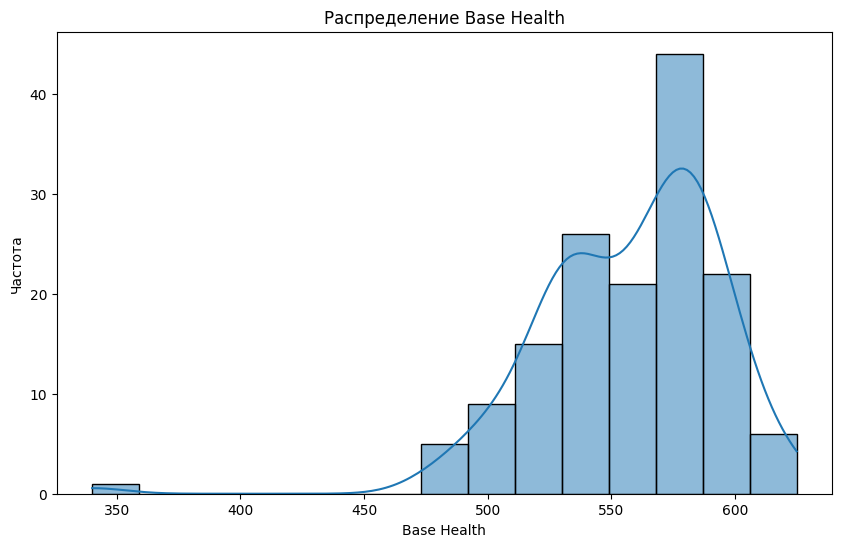

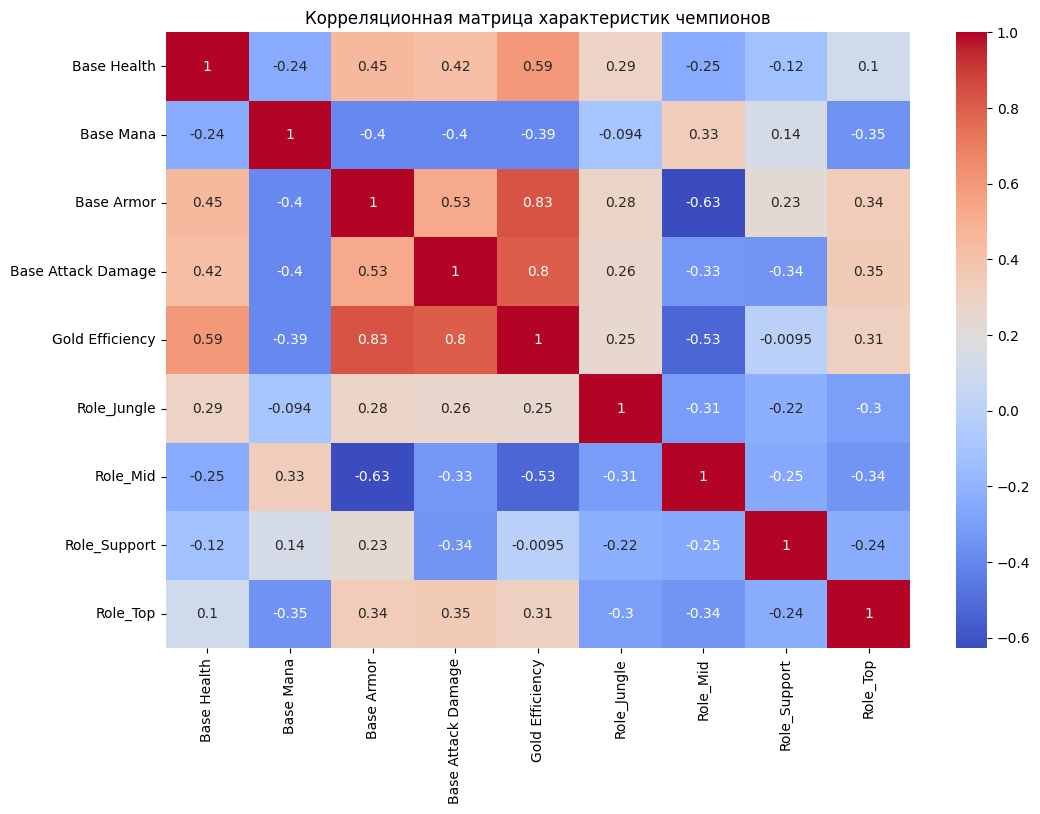

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение базовых характеристик чемпионов
plt.figure(figsize=(10, 6))
sns.histplot(data['Base Health'], kde=True)
plt.title('Распределение Base Health')
plt.xlabel('Base Health')
plt.ylabel('Частота')
plt.show()

# Закодируем категориальные признаки перед построением корреляционной матрицы
data_encoded = pd.get_dummies(data.drop(columns=['Champion Name']), drop_first=True)

# Корреляционная матрица
plt.figure(figsize=(12, 8))
correlation_matrix = data_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица характеристик чемпионов')
plt.show()


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Целевой признак
X = data.drop(columns=['Champion Name', 'Gold Efficiency'])
y = data['Gold Efficiency']

# Конвертация категориальных признаков
X = pd.get_dummies(X, columns=['Role'], drop_first=True)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Модели для обучения
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Обучение и оценка моделей
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R^2': r2_score(y_test, y_pred)
    }

# Вывод результатов
results_df = pd.DataFrame(results).T
print(results_df)


                                MSE       MAE       R^2
Linear Regression          0.000032  0.004790  0.907069
Random Forest              0.000071  0.006583  0.792623
Support Vector Regression  0.000530  0.018333 -0.544189
K-Nearest Neighbors        0.000078  0.007467  0.771577


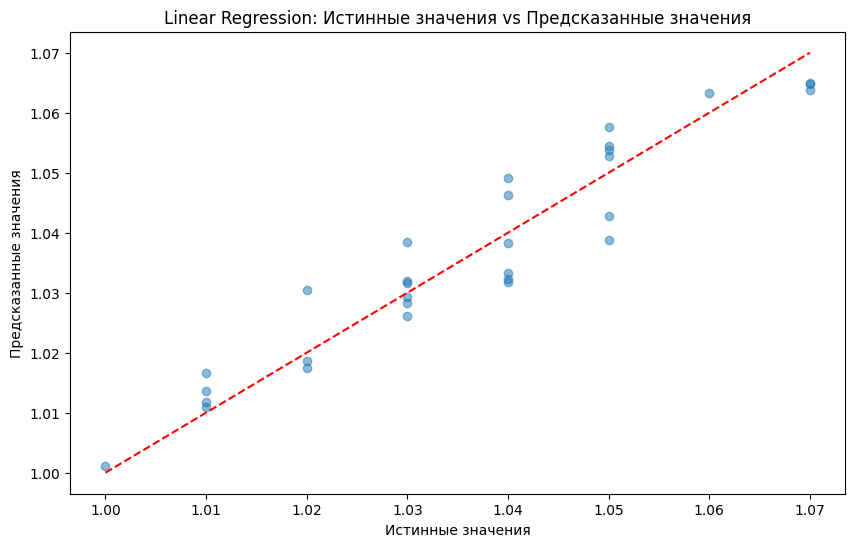

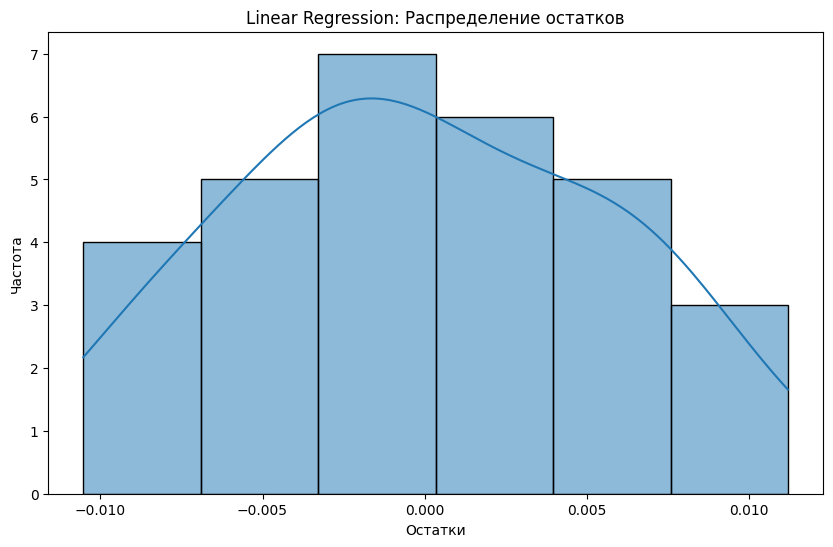

In [32]:
# Лучшая модель
best_model_name = results_df['R^2'].idxmax()
best_model = models[best_model_name]

# Построение графиков для диагностики
y_pred = best_model.predict(X_test_scaled)

# График "Истинные значения vs Предсказанные значения"
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'{best_model_name}: Истинные значения vs Предсказанные значения')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.show()

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title(f'{best_model_name}: Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# Точки на графике "Истинные значения vs Предсказанные значения" располагаются вдоль диагональной линии: Это означает, что модель делает точные предсказания, и ошибки минимальны.
# Распределение остатков нормальное: Это хороший признак, указывающий на то, что ошибки модели случайны и нет систематического смещения.
# Если есть значительные отклонения от диагональной линии и остатки имеют смещение: Это может указывать на необходимость доработки модели, возможно, с помощью подбора гиперпараметров или использования более сложных моделей.
# Эти графики помогают нам понять, насколько хорошо модель работает, и определить возможные области для улучшения.


In [33]:
from sklearn.ensemble import VotingRegressor

# Создание ансамбля из лучших моделей
ensemble_model = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('svr', SVR()),
    ('knn', KNeighborsRegressor())
])

# Обучение ансамблевой модели
ensemble_model.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# Оценка ансамблевой модели
ensemble_results = {
    'MSE': mean_squared_error(y_test, y_pred_ensemble),
    'MAE': mean_absolute_error(y_test, y_pred_ensemble),
    'R^2': r2_score(y_test, y_pred_ensemble)
}

# Вывод результатов ансамблевой модели
print(pd.DataFrame(ensemble_results, index=['Ensemble Model']))


                     MSE      MAE       R^2
Ensemble Model  0.000087  0.00738  0.747533


In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target feature
X = data.drop(columns=['Champion Name', 'Gold Efficiency'])
y = data['Gold Efficiency']

# Convert categorical features
X = pd.get_dummies(X, columns=['Role'], drop_first=True)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models for training
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Training and evaluating models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R^2': r2_score(y_test, y_pred)
    }

# Output results
results_df = pd.DataFrame(results).T
results_df


,MSE,MAE,R^2
Linear Regression,0.000032,0.004790,0.907069
Random Forest,0.000071,0.006583,0.792623
Support Vector Regression,0.000530,0.018333,-0.544189
K-Nearest Neighbors,0.000078,0.007467,0.771577


В данной контрольной работе была выполнена постановка задачи машинного обучения на основе датасета чемпионов League of Legends. Проведен анализ и обработка данных, включающие первичный анализ, предобработку, разведывательный анализ, создание и отбор признаков, подготовку данных. Выбраны метрики для оценки моделей, построены и оценены четыре модели машинного обучения. Проведена диагностика лучшей модели, построена и оценена ансамблевая модель.
